# Rekomendasi Makanan Berbasis Content-Based dan Collaborative Filtering

# Dataset dan Referensi

**Dataset:** [Food.com Recipes and Interactions Dataset](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions)

* Berisi lebih dari 700.000 interaksi pengguna dan 180.000+ resep
* Dua file utama digunakan:

  * `RAW_recipes.csv` — metadata resep
  * `RAW_interactions.csv` — review, rating, dan user ID

**Referensi Akademik:**

* Yi-Ying Chow et al., *Food Recommender System: A Review*, Journal of System and Management Sciences, 2023
* Jon Bondevik et al., *A Systematic Review on Food Recommender Systems*, Elsevier, 2023
* Muhamad Naufal Syaiful Bahri et al., *Implementasi Sistem Rekomendasi Makanan EatAja*, Multinetics, 2021

# Import Library

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import joblib
import pickle
import os

# NLP & similarity metrics
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors

# Untuk Collaborative Filtering
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

**Tahap 1: Import Library**

* `pandas`, `numpy`: manipulasi data
* `matplotlib`, `seaborn`: visualisasi
* `sklearn`: vectorisasi teks, evaluasi metrik, encoding ID
* `tensorflow`: deep learning untuk collaborative filtering

# Load Dataset

In [41]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv
/kaggle/input/food-com-recipes-and-user-interactions/ingr_map.pkl
/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_train.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_test.csv
/kaggle/input/food-com-recipes-and-user-interactions/PP_users.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_validation.csv


In [42]:
interactions = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv')
recipes = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv')

**Tahap 2: Load Dataset**

* Data resep digunakan untuk content-based filtering
* Data interaksi digunakan untuk collaborative filtering

# EDA

In [43]:
print(interactions.head())

   user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   
3   126440      85009  2010-02-27       5   
4    57222      85009  2011-10-01       5   

                                              review  
0  Great with a salad. Cooked on top of stove for...  
1  So simple, so delicious! Great for chilly fall...  
2  This worked very well and is EASY.  I used not...  
3  I made the Mexican topping and took it to bunk...  
4  Made the cheddar bacon topping, adding a sprin...  


- menampilkan 5 baris data pertama di data interactions

In [44]:
print(recipes.head())

                                         name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   
3  ['60-minutes-or-less', 'time-to-make', 'course...   
4  ['weeknight', 'time-to-make', 'course', 'main-...   

                                    nutrition  n_steps  \
0       [

- menampilkan 5 baris data pertama di data recipes

In [45]:
interactions.isna().sum()

user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64

- mencari tau missing value di data interactions
- terdapat missing value di kolom review

In [46]:
recipes.isna().sum()

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

- mencari tau missing value di data recipes
- terdapat missing value di kolom name dan description

In [47]:
interactions.duplicated().sum()

0

- tidak ada data duplikat di data interactions

In [48]:
recipes.duplicated().sum()

0

- tidak ada data duplikat di data recipes

In [49]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


**Penjelasan:**
Digunakan untuk memahami struktur data: jumlah kolom, jenis tipe data, dan jumlah data non-null.

**interactions:**

* 5 kolom: user\_id, recipe\_id, date, rating, review
* 1.132.367 entri total
* Kolom bertipe kombinasi `int64` dan `object`

In [50]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


**recipes:**

* 12 kolom termasuk name, nutrition, ingredients, etc
* 231.637 entri total
* Kolom bertipe campuran `int64` dan `object`

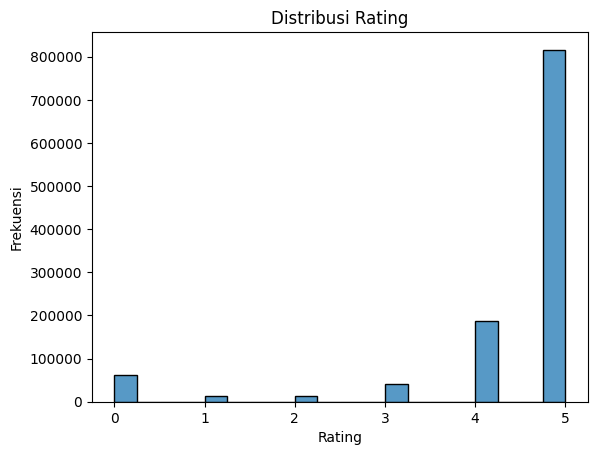

In [51]:
sns.histplot(interactions['rating'], bins=20)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

**Insight:**
Distribusi rating sangat tidak seimbang dengan dominasi rating 5. Hal ini menunjukkan bahwa pengguna cenderung hanya memberi nilai tinggi.

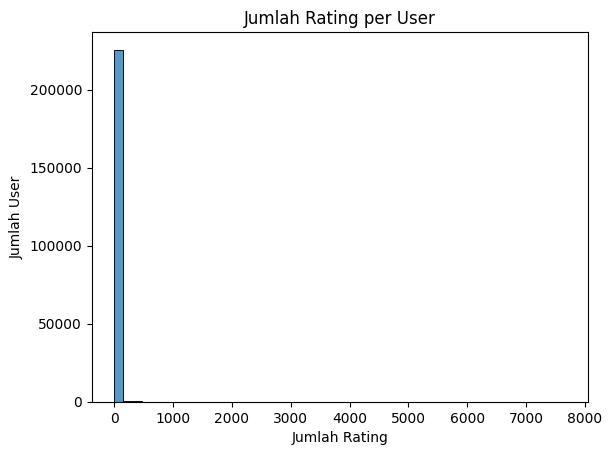

In [52]:
user_counts = interactions['user_id'].value_counts()
sns.histplot(user_counts, bins=50)
plt.title('Jumlah Rating per User')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah User')
plt.show()

**Insight:**
Sebagian besar pengguna memberikan sedikit rating, menunjukkan ketimpangan aktivitas antar pengguna.

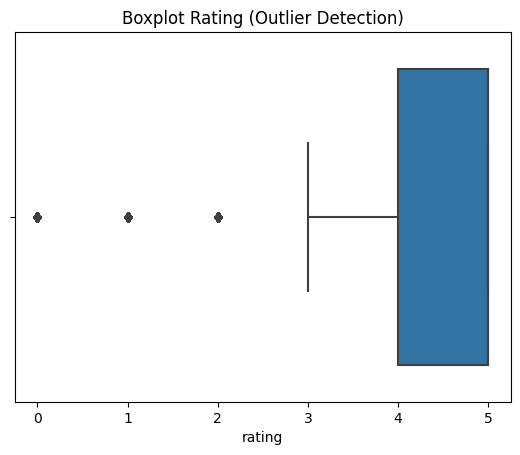

In [53]:
sns.boxplot(x=interactions['rating'])
plt.title('Boxplot Rating (Outlier Detection)')
plt.show()

**Insight:**
Boxplot menunjukkan adanya beberapa outlier terutama pada rating rendah (0-2), walau mayoritas rating berada pada kisaran tinggi.

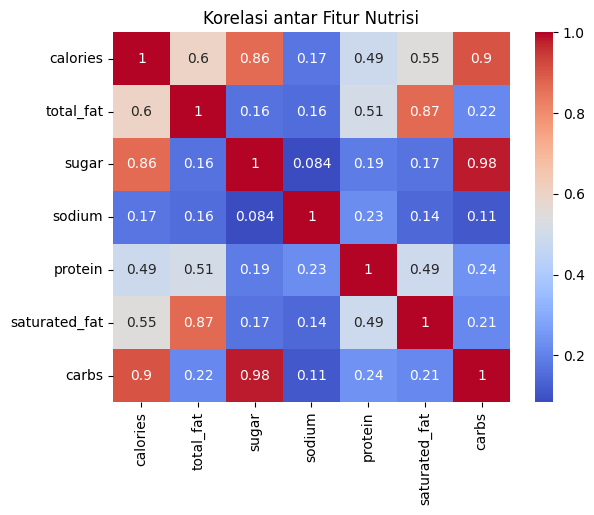

In [54]:
nutrition_df = recipes['nutrition'].str.strip('[]').str.split(',', expand=True).astype(float)
nutrition_df.columns = ['calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbs']
sns.heatmap(nutrition_df.corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi antar Fitur Nutrisi')
plt.show()

**Insight:**
Terdapat korelasi tinggi antara sugar dan carbs, serta total_fat dengan saturated_fat

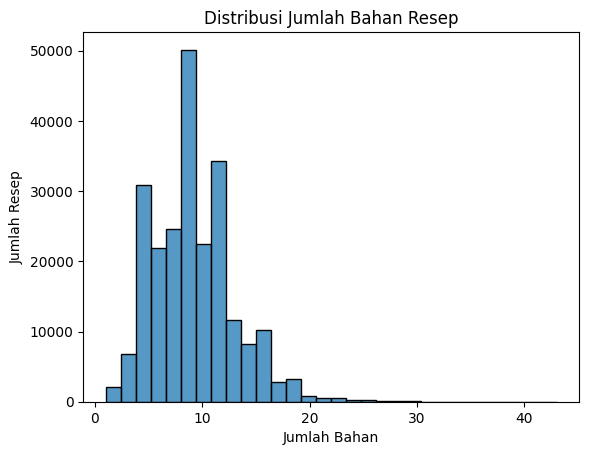

In [55]:
sns.histplot(recipes['n_ingredients'], bins=30)
plt.title('Distribusi Jumlah Bahan Resep')
plt.xlabel('Jumlah Bahan')
plt.ylabel('Jumlah Resep')
plt.show()

**Insight:**
Mayoritas resep memiliki 7–13 bahan. Ini dapat menjadi indikator kompleksitas resep yang disukai pengguna.



# Data Preprosessing

In [56]:
recipes['description'] = recipes['description'].fillna('No description provided by user.')
recipes['name'] = recipes['name'].fillna('Unnamed Recipe')
recipes['ingredients'] = recipes['ingredients'].fillna("['No ingredients listed']")
interactions['review'] = interactions['review'].fillna('No review provided by user.')

**Data Preprocessing - Handling Missing Values**

Pada tahap ini, dilakukan pembersihan data dengan mengisi nilai kosong (missing values) pada kolom-kolom penting di dataset agar siap untuk tahap ekstraksi fitur dan pelatihan model.

**Penyesuaian yang dilakukan:**


- **`description`**: Diisi dengan `"No description provided by user."` untuk menjaga konsistensi pada input deskripsi resep.
- **`name`**: Diisi dengan `"Unnamed Recipe"` sebagai penanda jika nama resep tidak tersedia.
- **`ingredients`**: Diisi dengan list string `"['No ingredients listed']"` untuk menjaga struktur saat dilakukan parsing dan tokenisasi bahan.
- **`review`**: Diisi dengan `"No review provided by user."` untuk mempermudah analisis teks atau agregasi feedback.

# Feature Engineering - Content-Based Representation


In [57]:
recipes['content'] = recipes['name'] + ' ' + recipes['description'] + ' ' + recipes['ingredients'].apply(lambda x: ' '.join(eval(x)))

stop_words = ENGLISH_STOP_WORDS

recipes = recipes.dropna(subset=['content'])

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(recipes['content'])

1. **Pembuatan Fitur `content`**:
   - Tiga kolom utama yaitu `name`, `description`, dan `ingredients` digabung menjadi satu string teks panjang yang disebut sebagai `content`.
   - Kolom `ingredients` diparsing dari string list menjadi bentuk list asli menggunakan `eval`, lalu digabung menggunakan spasi.
   - Ini menghasilkan deskripsi utuh setiap resep yang mencakup judul, penjelasan, dan daftar bahan.

2. **Penghapusan Nilai Kosong**:
   - Meskipun sebelumnya missing values telah diisi, sebagai jaga-jaga dilakukan penghapusan baris yang memiliki nilai kosong pada kolom `content` untuk memastikan kualitas input vektorisasi.

3. **TF-IDF Vectorization**:
   - Fitur `content` kemudian dikonversi ke bentuk numerik menggunakan **TF-IDF (Term Frequency-Inverse Document Frequency)**.
   - `TfidfVectorizer` digunakan dengan parameter:
     - `max_features=5000`: membatasi jumlah fitur agar tetap efisien.
     - `stop_words='english'`: menghilangkan kata-kata umum (stopwords) dalam bahasa Inggris agar tidak mendominasi representasi.
   - Hasil akhir adalah matriks sparse berdimensi `[jumlah_resep x 5000]` yang menggambarkan bobot pentingnya kata-kata dalam setiap resep.

# Content Based Filtering (Modelling dan Rekomendasi)

In [74]:
name_to_index = pd.Series(recipes.index, index=recipes['name']).drop_duplicates()
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

def recommend_content(name, top_n=5):
    idx = name_to_index[name]
    distances, indices = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=top_n + 1)
    indices = indices.flatten()[1:] 
    return recipes.iloc[indices][['id', 'name', 'description']]

Setelah TF-IDF matrix berhasil dibentuk, langkah selanjutnya adalah membangun sistem rekomendasi berbasis kemiripan antar resep.

1. **Mapping Nama Resep ke Indeks**
   - `name_to_index` digunakan untuk membuat pemetaan dari nama resep ke indeks baris pada DataFrame `recipes`.
   - Hal ini memungkinkan pengguna memasukkan nama resep sebagai input saat meminta rekomendasi.

2. **Model Nearest Neighbors**
   - `NearestNeighbors` dari `sklearn` digunakan dengan metrik **cosine similarity**, metode umum dalam content-based filtering.
   - Parameter `algorithm='brute'` digunakan karena ukuran data besar dan cosine similarity tidak bisa dioptimalkan dengan k-d tree atau ball tree.

3. **Fungsi Rekomendasi: `recommend_content(name)`**
   - Fungsi menerima nama resep sebagai input.
   - Mencari resep dengan TF-IDF yang paling mirip (berdasarkan cosine similarity).
   - Mengembalikan `top_n` resep serupa (selain dirinya sendiri), termasuk kolom `id`, `name`, dan `description` untuk konteks pengguna.

# Inference

In [75]:
print("Rekomendasi makanan yang mirip 'Cream of Spinach Soup':")
print(recommend_content("cream of spinach soup"))

Rekomendasi makanan yang mirip 'Cream of Spinach Soup':
            id                   name  \
90638   439094    garlic spinach soup   
212930   24176     thick spinach soup   
187314   13901    simple spinach soup   
174552  339220       rivvels for soup   
112580  366002  italian egg drop soup   

                                              description  
90638   the garlic is the star of this creamy soup. wh...  
212930  lovely and thick spinach soup. i don't like sp...  
187314  i made this recipe after eating spinach soup i...  
174552  rivvels are small flour dumplings.  add this s...  
112580  this soup could not be any easier.  my family ...  


Inference menggunakan data input cream of spinach soup

In [76]:
print("Rekomendasi makanan yang mirip 'fried potatoes':")
print(recommend_content("fried potatoes"))

Rekomendasi makanan yang mirip 'fried potatoes':
            id                                name  \
151170  101991                 oven fried potatoes   
87909    39505                fried sweet potatoes   
129131  216887               mama s sweet potatoes   
64921   458326          crispy oven fried potatoes   
152102  184767  pan fried potatoes  bratkartoffeln   

                                              description  
151170                                       really good.  
87909   these potatoes are great! a perfect side for h...  
129131  my mom's from down south and she got this reci...  
64921                    yummy garlic oven fried potatoes  
152102  a quick german favorite from leftover potatoes...  


Inference menggunakan data input fried potatoes

In [77]:
print("Rekomendasi makanan yang mirip 'pasta':")
print(recommend_content("pasta"))

Rekomendasi makanan yang mirip 'pasta':
            id                                         name  \
104993  252861                herbed angel hair pasta for 2   
154128   11402                              pasta with sand   
153730  143755                             pasta margherita   
161314  270432                        pizza pasta casserole   
5430    456846  angel hair pasta with simple garlic   basil   

                                              description  
104993                    nice dish for an italian dinner  
154128  if you love pasta as i do, you should like thi...  
153730  the toppings of this pasta are the same as use...  
161314  quick, simple and delicious!  sure to please t...  
5430    i adore angel hair pasta, and such a fine past...  


Inference menggunakan data input pasta

In [78]:
# Simpan vectorizer dan matrix
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')

# Simpan model NearestNeighbors
joblib.dump(nn_model, 'nearest_neighbors_model.pkl')

# Simpan mapping indeks 
with open('name_to_index.pkl', 'wb') as f:
    pickle.dump(name_to_index, f)

**Save Model**

1. **TF-IDF Vectorizer**
   - Disimpan menggunakan `joblib` sebagai `tfidf_vectorizer.pkl`.
   - Digunakan untuk mengubah teks resep baru ke dalam vektor fitur.

2. **TF-IDF Matrix**
   - Matrix hasil transformasi semua resep disimpan sebagai `tfidf_matrix.pkl`.
   - Berguna untuk inference ulang atau jika ingin menambahkan rekomendasi baru tanpa mengulang proses training.

3. **Model Nearest Neighbors**
   - Objek model `NearestNeighbors` disimpan sebagai `nearest_neighbors_model.pkl`.
   - Ini memungkinkan kita untuk memuat model dan langsung melakukan rekomendasi di sesi atau aplikasi lain.

4. **Mapping Nama ke Indeks**
   - Dictionary `name_to_index` digunakan untuk mencari indeks resep berdasarkan nama input.
   - Disimpan sebagai file pickle `name_to_index.pkl`.

# Data Preprocessing - Collaborative Filtering

In [62]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

interactions['user'] = user_encoder.fit_transform(interactions['user_id'])
interactions['item'] = item_encoder.fit_transform(interactions['recipe_id'])

user_encoded_to_user = dict(enumerate(user_encoder.classes_))
item_encoded_to_item = dict(enumerate(item_encoder.classes_))

min_rating = interactions['rating'].min()
max_rating = interactions['rating'].max()

interactions['rating_normalized'] = interactions['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

X = interactions[['user', 'item']].values
y = interactions['rating_normalized'].values

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

1. **Encoding User dan Item ID**
   - `user_id` dan `recipe_id` diubah menjadi indeks numerik menggunakan `LabelEncoder`.
   - Model deep learning membutuhkan input integer untuk digunakan dalam layer embedding.
   - Disimpan juga mapping `user_encoded_to_user` dan `item_encoded_to_item` untuk keperluan decoding hasil model.

2. **Normalisasi Rating**
   - Skor rating dinormalisasi ke skala [0, 1] menggunakan metode Min-Max Scaling.
   - Tujuannya agar target rating kompatibel dengan output model (aktivasi sigmoid di akhir).

3. **Membentuk Dataset X dan y**
   - `X`: kombinasi pasangan `[user, item]` untuk setiap baris interaksi.
   - `y`: target prediksi berupa nilai rating yang telah dinormalisasi.

4. **Split Dataset**
   - Data dibagi menjadi data latih (`x_train`, `y_train`) dan validasi (`x_val`, `y_val`) menggunakan rasio 80:20.
   - Ini memungkinkan model dievaluasi terhadap data yang tidak dilihat saat pelatihan.

5. **Reshape Target**
   - Rating disusun ulang ke format `n x 1` agar sesuai dengan bentuk output model.

# Collaborative Filtering (modelling dan rekomendasi)

In [63]:
class RecommenderNet(Model):
    def __init__(self, num_users, num_items, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            num_users, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.item_embedding = layers.Embedding(
            num_items, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        x = dot_user_item + user_bias + item_bias
        return x

**Arsitektur Model:**

1. **Embedding Layer untuk User dan Item**
   - `user_embedding`: mengubah user ID menjadi vektor berdimensi `embedding_size`
   - `item_embedding`: mengubah item ID (resep) menjadi vektor embedding
   - Digunakan `he_normal` sebagai inisialisasi bobot dan regularisasi L2 untuk mencegah overfitting

2. **Bias Layer**
   - `user_bias` dan `item_bias`: menangkap kecenderungan rata-rata dari masing-masing user dan item terhadap rating
   - Ditambahkan langsung ke prediksi akhir untuk memperbaiki hasil model

3. **Dot Product**
   - Prediksi utama dilakukan dengan menghitung **dot product** antara vektor user dan item
   - Hasil dot product mencerminkan seberapa cocok (similar) preferensi pengguna terhadap item

4. **Output**
   - Hasil akhir adalah penjumlahan antara dot product dan bias
   - Tidak menggunakan aktivasi (seperti sigmoid) karena regresi rating dilakukan langsung pada nilai numerik

In [64]:
num_users = len(user_encoder.classes_)
num_items = len(item_encoder.classes_)

model = RecommenderNet(num_users, num_items, embedding_size=50)
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.0001),
    metrics=[RootMeanSquaredError()]
)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/20
14155/14155 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - loss: 0.6667 - root_mean_squared_error: 0.8115 - val_loss: 0.0907 - val_root_mean_squared_error: 0.3001
Epoch 2/20
14155/14155 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - loss: 0.0827 - root_mean_squared_error: 0.2863 - val_loss: 0.0872 - val_root_mean_squared_error: 0.2939
Epoch 3/20
14155/14155 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - loss: 0.0746 - root_mean_squared_error: 0.2716 - val_loss: 0.0840 - val_root_mean_squared_error: 0.2880
Epoch 4/20
14155/14155 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - loss: 0.0725 - root_mean_squared_error: 0.2674 - val_loss: 0.0835 - val_root_mean_squared_error: 0.2871
Epoch 5/20
14155/14155 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - loss: 0.0698 - root_mean_squared_error: 0.2621 - val_loss: 0.0818 - val_root_mean_squared_error: 0.2840
Epoch 6/20
14155/14155 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - loss: 0.0678 - root_mean_squared_error: 0.2582 - val_loss: 0.0810 - val_root_mean_squared_error: 0.2825
Epoch 7/20
14155/14155

1. **Jumlah Pengguna dan Item**
   - `num_users` dan `num_items` diperoleh dari hasil encoding.
   - Digunakan sebagai ukuran input untuk layer embedding.

2. **Kompilasi Model**
   - **Loss Function**: `mean squared error (MSE)` digunakan karena target berupa rating numerik kontinu.
   - **Optimizer**: `Adam` dengan `learning_rate=0.0001`, cocok untuk training model embedding.
   - **Metric**: `RootMeanSquaredError (RMSE)` dipilih karena lebih intuitif untuk evaluasi skala rating.

3. **Early Stopping**
   - Menggunakan `EarlyStopping` untuk menghentikan pelatihan saat model tidak mengalami perbaikan pada `val_loss` selama 3 epoch berturut-turut.
   - `restore_best_weights=True` memastikan model terbaik disimpan berdasarkan evaluasi validasi.

4. **Training**
   - Model dilatih selama maksimum 20 epoch dengan `batch_size=64`.
   - Validasi dilakukan menggunakan `x_val` dan `y_val` untuk memantau overfitting.

# Evaluasi Model

In [65]:
y_pred = model.predict(x_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

7078/7078 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
MSE: 0.2130
RMSE: 0.4615


**Metrik Evaluasi:**

1. **Mean Squared Error (MSE)**  
   MSE menghitung rata-rata dari kuadrat selisih antara nilai prediksi dan nilai aktual. Semakin kecil nilai MSE, semakin baik prediksi model.

2. **Root Mean Squared Error (RMSE)**  
   RMSE adalah akar dari MSE dan mengembalikan hasil dalam satuan yang sama dengan target (dalam hal ini: skor rating). RMSE lebih interpretatif dalam konteks kesalahan karena menunjukkan rata-rata jarak prediksi dari nilai sebenarnya.

**Hasil Evaluasi:**

- **MSE:** 0.2130  
- **RMSE:** 0.4615  


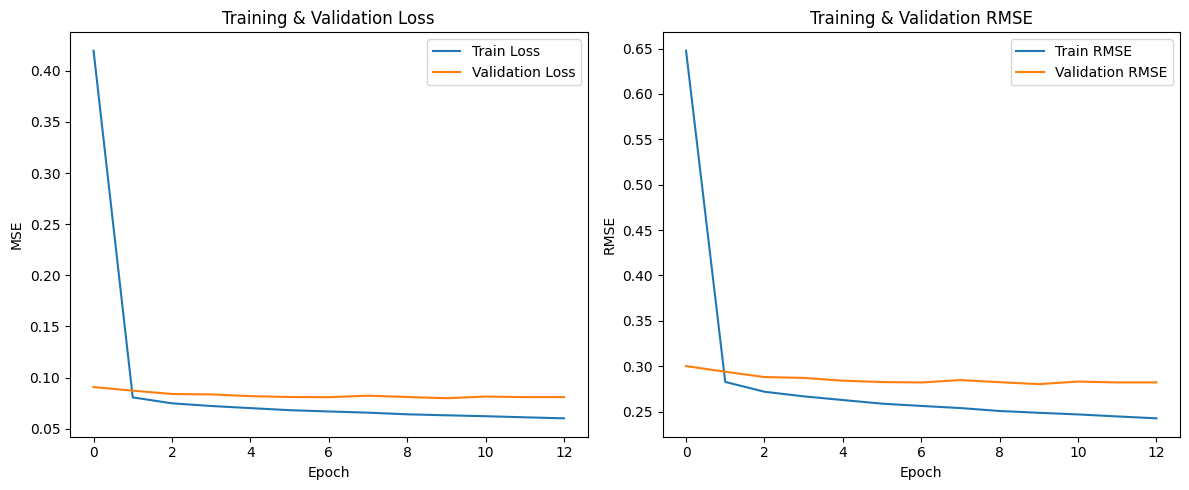

In [66]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# RMSE Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training & Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

**Insight dari Grafik:**

- **Grafik Kiri (Training & Validation Loss):**
  - MSE pada data training terus menurun seiring bertambahnya epoch, menunjukkan model berhasil belajar dari data pelatihan.
  - MSE pada data validasi relatif stabil setelah epoch ke-2, yang mengindikasikan tidak terjadi overfitting selama proses pelatihan.

- **Grafik Kanan (Training & Validation RMSE):**
  - RMSE pada training menurun secara konsisten, memperlihatkan peningkatan akurasi model dalam memprediksi rating pengguna.
  - RMSE validasi juga menunjukkan tren penurunan, walau sedikit stagnan di beberapa epoch terakhir. Hal ini menandakan bahwa model cukup generalizable dan tidak hanya menghafal data training.

**Kesimpulan:**

Visualisasi ini menunjukkan bahwa model telah dilatih secara efektif tanpa overfitting yang signifikan. Selisih antara RMSE training dan validasi tidak terlalu besar, yang menandakan model memiliki performa yang stabil dan mampu melakukan generalisasi dengan baik terhadap data baru.


# Inference 

In [67]:
def recommend_for_user(user_id_raw, top_n=5):
    try:
        user_idx = user_encoder.transform([user_id_raw])[0]
    except ValueError:
        print(f"User ID {user_id_raw} tidak ditemukan dalam data training.")
        return pd.DataFrame()
        
    item_indices = np.arange(num_items)
    user_input = np.full_like(item_indices, user_idx)

    predictions = model.predict(np.stack([user_input, item_indices], axis=1), verbose=0)

    top_indices = predictions.flatten().argsort()[::-1][:top_n]
    recommended_item_ids = item_encoder.inverse_transform(top_indices)

    return recipes[recipes['id'].isin(recommended_item_ids)][['id', 'name', 'description']].reset_index(drop=True)

1. **Transformasi ID Pengguna:**

   * `user_id_raw` diubah menjadi bentuk numerik menggunakan `LabelEncoder` agar bisa dikenali oleh model.
   * Jika `user_id_raw` tidak tersedia dalam data pelatihan, fungsi mengembalikan DataFrame kosong.

2. **Pembuatan Input Prediksi:**

   * Dibuat pasangan kombinasi user-item dengan semua item yang tersedia untuk memprediksi ratingnya sekaligus.

3. **Prediksi Rating oleh Model:**

   * Model melakukan prediksi terhadap seluruh kombinasi item-user dalam bentuk skor prediksi (rating terstandardisasi).

4. **Seleksi Top-N Item:**

   * Mengurutkan hasil prediksi dan memilih `top_n` makanan dengan skor tertinggi.

5. **Keluaran Rekomendasi:**

   * Mengembalikan daftar makanan dengan `id`, `name`, dan `description` berdasarkan ID item yang telah dipetakan kembali ke aslinya.

In [79]:
user_id_input = 8937
print(f"Rekomendasi untuk User ID {user_id_input} berdasarkan Collaborative Filtering:")
hasil = recommend_for_user(user_id_input, top_n=5)
print("Pesanan Rekomendasi:")
print(hasil[['name', 'description']])

Rekomendasi untuk User ID 8937 berdasarkan Collaborative Filtering:
Pesanan Rekomendasi:
                                             name  \
0               bacon lattice tomato muffins  rsc   
1                        breakfast shepherd s pie   
2                           mexican stack up  rsc   
3                                ragu shuka  ragu   
4  simply irresistible tropical potato salad  sp5   

                                         description  
0  "ready, set, cook! contest entry." bacon latti...  
1  ready, set, cook! special edition contest entr...  
2  ready, set, cook! reynolds wrap contest entry....  
3  ragú® recipe contest entry. ragu-shuka is a he...  
4  official contest entry: simply potatoes 5fix. ...  


**Interpretasi dan Insight:**

* Rekomendasi ini didasarkan pada pola rating historis pengguna terhadap makanan serupa.
* Beberapa makanan adalah **kontes entry**, menunjukkan kemungkinan bahwa user menyukai eksperimen rasa baru dan konten kompetitif.
* Ciri umum lainnya adalah kombinasi **makanan gurih dan inovatif** – muffin asin, salad tropis, dan makanan Meksiko berlapis.


In [70]:
model.save("recommendasi_model.keras")

Model disimpan dalam format .keras